<a href="https://colab.research.google.com/github/wFairmanOlin/Biomass/blob/master/Prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --upgrade pip

In [ ]:
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import pandas as pd
from datetime import datetime
import firebase_admin
from firebase_admin import db
from firebase_admin import credentials
import pytz

# Import from Firebase

To download data from firebase, you must have a unique key stored locally. The key will not be available from github and should not be uploaded to github. The following code currently downloads all the data from Firebase, as our database grows, future versions should look into only downloading the latest data

In [ ]:
### ONLY RUN ONCE! ###
#download data from firebase
cred = credentials.Certificate("/content/haucs-monitoring-firebase-adminsdk-wt1pb-1291f2083e.json")
firebase_admin.initialize_app(cred, {'databaseURL': 'https://haucs-monitoring-default-rtdb.firebaseio.com'})

In [ ]:
## ONLY RUN TO REFRESH DATA! ###
ref = db.reference('/')
data = ref.get()

### RUN TO SAVE JSON FILE LOCALLY ###
with open('latest_data.json', 'w') as f:
    json.dump(data, f)

# Date Time
Firebase stores the time of data entries as a local datetime string. Due to daylight savings issues, we have to be careful with how to process datetime objects. The following code block handles converting local datetime objects into timezone aware datetime objects.

For data analysis, the date time objects should probably be converted into timestamps.

In [ ]:
def to_datetime(dates, tz_aware=True):
    dt = []
    for i in dates:
        if "T" in i or "-" in i:
          i = i.replace("T","_")
          i = i.replace("-","")
        i_dt = datetime.strptime(i, "%Y%m%d_%H:%M:%S")
        # i_dt = datetime.fromisoformat(date)
        
        if tz_aware:
            tz = pytz.timezone('US/Eastern')
            i_dt = tz.localize(i_dt)

        dt.append(i_dt)
    return dt

#time
example = datetime.fromisoformat("2023-03-12T01:30:05")
#time zone aware current time
# example_aware = to_datetime([str(example)])[0]

print("unaware time: ", example)
# print("aware time: ", example_aware)

print("unaware timestamp", example.timestamp())
# print("aware timestamp", example_aware.timestamp())

unaware time:  2023-03-12 01:30:05
unaware timestamp 1678584605.0


# Local Data
Harvest results and sensor anomalies are recorded locally. The sensor log file keeps track of any anomalies that occur with the sensor.
<table>
<tr> <th>Event</th>	<th>Description</th>	<th>Value</th></tr>
<tr> <td>i</td>	<td>installed in a tank</td>	<td>tank installed in</td></tr>
<tr> <td>r</td>	<td>removed from a tank</td>	<td>tank removed from</td></tr>
<tr> <td>c</td>	<td>debris cleaned from sensor</td>	<td>N/A</td></tr>
<tr> <td>f</td>	<td>sensor failure leading to missing data</td>	<td>N/A</td></tr>
</table>

In [ ]:
## information regarding sensor installments/removals
## ID - biomass sensor (not algae tank)
df_anomaly = pd.read_csv('sensor_log.csv')
df_anomaly['datetime'] = to_datetime(df_anomaly.Date)

## information regarding algae harvests
## Before - algae (kg) in tank before harvest
## After  - algae (kg) in tank after harvest
## ID - algae tank
df_harvest = pd.read_csv('harvest_log.csv')
df_harvest['datetime'] = to_datetime(df_harvest.Date)
print(df_anomaly.head())
print("\n", df_harvest.head())

                  Date  ID Event  Value                  datetime
0  2023-04-11T09:00:00   1     r    1.0 2023-04-11 09:00:00-04:00
1  2023-04-11T13:30:00   1     i    2.0 2023-04-11 13:30:00-04:00
2  2023-04-12T17:30:00   3     f    NaN 2023-04-12 17:30:00-04:00
3  2023-04-13T10:00:00   2     r    1.0 2023-04-13 10:00:00-04:00
4  2023-04-13T18:00:00   2     i    2.0 2023-04-13 18:00:00-04:00

                   Date  ID  Before  After                  datetime
0  2023-02-03T12:00:00   3   39.71  22.11 2023-02-03 12:00:00-05:00
1  2023-02-09T12:00:00   3   36.90  22.11 2023-02-09 12:00:00-05:00
2  2023-02-16T12:00:00   3   46.30  22.11 2023-02-16 12:00:00-05:00
3  2023-02-22T12:00:00   3   43.01  22.11 2023-02-22 12:00:00-05:00
4  2023-03-02T12:00:00   3   44.40  22.11 2023-03-02 12:00:00-05:00


# Processing Sensor Data

In [ ]:
def moving_average(x, n=4):
    '''
    Simple moving average filter
    '''
    filter = np.ones(n) / n
    return np.convolve(x, filter, 'same')

class bmass_sensor():

    def __init__(self, name, data):
        self.d_dt = to_datetime(data[name]['data'])
        self.s_dt = to_datetime(data[name]['status'])
        self.on = np.array([int(data[name]['data'][i][1]) for i in data[name]['data']])
        self.off = np.array([int(data[name]['data'][i][0]) for i in data[name]['data']])
        self.g = np.array([int(data[name]['data'][i][2]) for i in data[name]['data']])
        self.battv = np.array([float(data[name]['status'][i]['batt_v']) for i in data[name]['status']])


bm1 = bmass_sensor('bmass_1', data)
bm2 = bmass_sensor('bmass_2', data)
bm3 = bmass_sensor('bmass_3', data)
bm4 = bmass_sensor('bmass_4', data)
bm5 = bmass_sensor('bmass_5', data)

In [ ]:
print("bm1: ", bm1.d_dt[-1], " ", bm1.on[-1], " ", bm1.off[-1], " ", bm1.g[-1])
print("bm2: ", bm2.d_dt[-1], " ", bm2.on[-1], " ", bm2.off[-1], " ", bm2.g[-1])
print("bm3: ", bm3.s_dt[-1], " ", bm3.on[-1], " ", bm3.off[-1], " ", bm3.g[-1])
print("bm4: ", bm4.d_dt[-1], " ", bm4.on[-1], " ", bm4.off[-1], " ", bm4.g[-1])
print("bm5: ", bm5.d_dt[-1], " ", bm5.on[-1], " ", bm5.off[-1], " ", bm5.g[-1])

bm1:  2023-04-21 12:31:10-04:00   614   531   1160
bm2:  2023-04-21 12:36:52-04:00   780   668   3189
bm3:  2023-04-21 12:31:12-04:00   780   782   65480
bm4:  2023-04-21 12:33:23-04:00   783   785   65480
bm5:  2023-04-21 12:36:16-04:00   782   545   5966


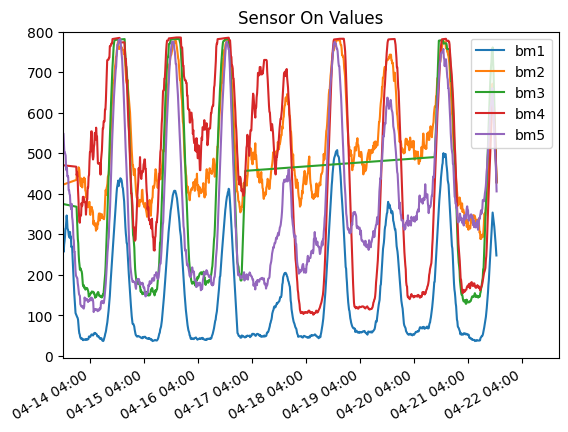

In [ ]:
# checking laser on values for all sensors
date_fmt = '%m-%d %H:%M'
# Use DateFormatter to set the data to the correct format.
date_formatter = mdates.DateFormatter(date_fmt)


lower = datetime(2023, 4, 13, hour=16)
#plot
plt.figure()
plt.plot(bm1.d_dt, moving_average(bm1.on, 20))
plt.plot(bm2.d_dt, moving_average(bm2.on, 20))
plt.plot(bm3.d_dt, moving_average(bm3.on, 20))
plt.plot(bm4.d_dt, moving_average(bm4.on, 20))
plt.plot(bm5.d_dt, moving_average(bm5.on, 20))
plt.xlim(left=lower)
plt.ylim(top=800)
plt.title("Sensor On Values")
plt.legend(['bm1','bm2', 'bm3', 'bm4', 'bm5'])
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_formatter)
plt.show()

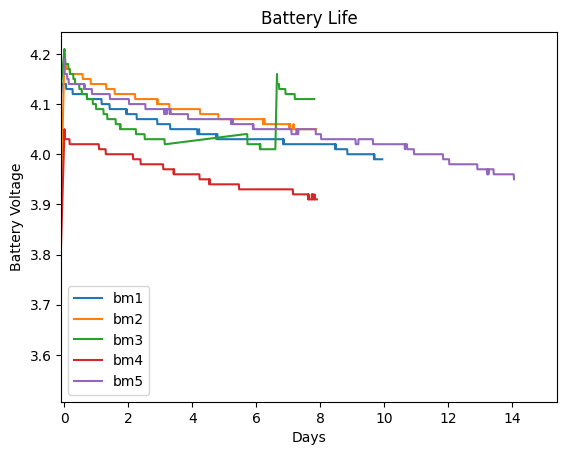

In [ ]:
# checking battery life
bm1_t = mdates.date2num(bm1.s_dt)
bm2_t = mdates.date2num(bm2.s_dt)
bm3_t = mdates.date2num(bm3.s_dt)
bm4_t = mdates.date2num(bm4.s_dt)
bm5_t = mdates.date2num(bm5.s_dt)

bm1_start = bm1_t[1633]
bm2_start = bm2_t[812]
bm3_start = bm3_t[723]
bm4_start = bm4_t[755]
bm5_start = bm5_t[0]


bm1_t = bm1_t - bm1_start
bm2_t = bm2_t - bm2_start
bm3_t = bm3_t - bm3_start
bm4_t = bm4_t - bm4_start
bm5_t = bm5_t - bm5_start

t = np.arange(1, len(bm2.battv) + 1) / 6 / 24
plt.figure()
plt.plot(bm1_t, bm1.battv)
plt.plot(bm2_t, bm2.battv)
plt.plot(bm3_t, bm3.battv)
plt.plot(bm4_t, bm4.battv)
plt.plot(bm5_t, bm5.battv)
plt.xlim(left=-.1)
plt.title("Battery Life")
plt.ylabel("Battery Voltage")
plt.xlabel("Days")
plt.legend(["bm1", "bm2", "bm3", "bm4", "bm5"], loc='lower left')
plt.show()

Int64Index([9, 10, 11], dtype='int64')
r
i
i


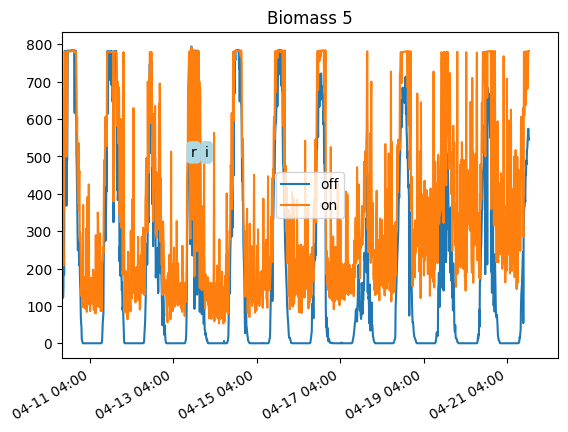

In [ ]:
id = 5
bmx = bm5
lower = datetime(2023, 4, 10, hour=12)
#plot
plt.figure()
plt.plot(bmx.d_dt, bmx.off)
plt.plot(bmx.d_dt, bmx.on)
plt.xlim(left=lower)
# plt.ylim(top=400)
plt.title("Biomass " + str(id))
plt.legend(['off', 'on'])
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_formatter)

#plot anomalies 
bmx_anomalies = df_anomaly.index[df_anomaly.ID == id]
print(bmx_anomalies)
for i in bmx_anomalies:
    print(df_anomaly.Event[i])
    text = str(df_anomaly.Event[i])
    pos = df_anomaly.datetime[i]
    plt.text(pos, 500, text,
                bbox=dict(boxstyle="round,pad=0.3", ec='none', fc='lightblue'))
plt.show()

#Deleting Data from Firebase
WARNING: this action will permanently alter the data in Firebase.

In [ ]:
# #select sensor and data or status path
# del_path = '/bmass_5/data'
# del_node = db.reference(del_path)
# #select start date for delete 
# del_start = datetime(2023, 4, 13, hour=10, minute=0)
# #select end date for delete
# del_end = datetime(2023, 4, 13, hour=18, minute=0)

# del_data = del_node.get()
# del_data_dt = []
# print("Deleting the Following Nodes: ", del_path)
# for i in del_data:
#     i_dt = datetime.fromisoformat(i)
#     if (del_start <= i_dt <= del_end):
#         print(i)
#         del_data_dt.append(i)
        
# #uncomment the following section to delete
# print("Should these nodes be deleted? (y/n)")
# # if (input('permanently delete (y/n): ') == 'y'):
# #     for i in del_data_dt:
# #         del_point = del_path + '/' + i
# #         del_point = db.reference(del_point)
# #         del_point.delete()

# Prediction Models


In [ ]:
pip install scalecast --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 878.9/878.9 kB 37.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 22.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 81.6 MB/s eta 0:00:00
  Created wheel for scalecast: filename=SCALECAST-0.18.2-py3-none-any.whl size=111874 sha256=7bb9ad3d3934c014c0b7ce84bbeb20281a9c8c1839b0b2ab7250591f41831495
  Stored in directory: /root/.cache/pip/wheels/e0/e9/3b/3b0b4472f38c3660d0b1bfb65332a00d805f280daff1d8adee
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107747 sha256=1b4c4414ece082f7a5df47d12ce10e5f3c206f1ef2cf67707fd3fd31b11dd95c


In [ ]:
dates = pd.to_datetime(bm1.d_dt)
values = bm1.on - bm1.off
df = pd.DataFrame({'ds': dates, 'y': values})

Filtering data for night-time

In [ ]:
start_time = '23:00:00'
end_time = '04:00:00'

# convert the 'ds' column to datetime type
df['ds'] = pd.to_datetime(df['ds'])

# filter the data between 11pm and 4am
filtered_data = df.set_index('ds').between_time(start_time, end_time)

# display the filtered data
print(filtered_data)

                             y
ds                            
2023-03-29 23:08:33-04:00  449
2023-03-29 23:19:35-04:00  444
2023-03-29 23:30:37-04:00  442
2023-03-29 23:41:39-04:00  438
2023-03-29 23:52:41-04:00  456
...                        ...
2023-04-21 03:11:49-04:00   32
2023-04-21 03:22:57-04:00   41
2023-04-21 03:34:44-04:00   26
2023-04-21 03:45:52-04:00   40
2023-04-21 03:57:01-04:00   30

[602 rows x 1 columns]


In [ ]:
from scalecast.Forecaster import Forecaster
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

In [ ]:
f = Forecaster(
    y = filtered_data['y'],
    current_dates= filtered_data.index,
    freq='11T'
)

In [ ]:
f

Forecaster(
    DateStartActuals=2023-03-30T03:08:33.000000000
    DateEndActuals=2023-04-21T07:57:01.000000000
    Freq=11T
    N_actuals=602
    ForecastLength=0
    Xvars=[]
    TestLength=0
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


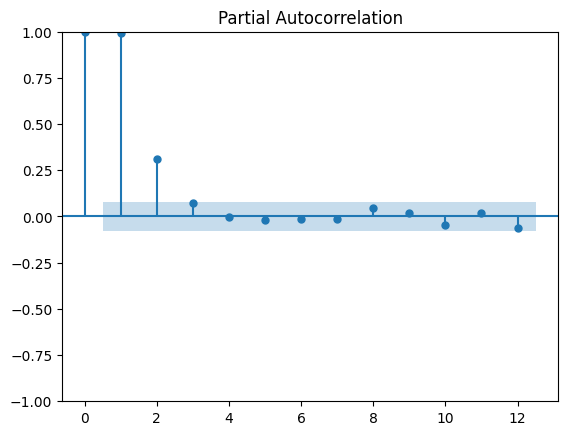

In [ ]:
f.plot_pacf(lags=12)
plt.show()

The PACF shows statistical correlation in 1 day values

# Augmented Dickey-Fuller test

This test is to see if the series is stationary or non-stationary

In [ ]:
stat, pval, _, _, _, _ = f.adf_test()

In [ ]:
print(f'Stat: {stat}')
print(f'P-value: {pval}')

Stat: -0.9160854124759042
P-value: 0.7826291179085016


As P-value is more than 0.05, the series can be assumed non-stationary

# ARIMA Forecasting

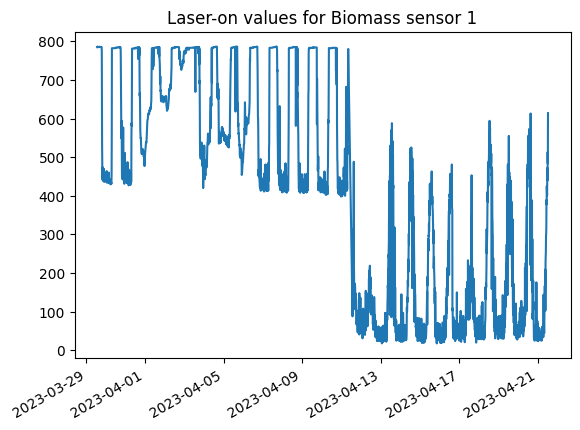

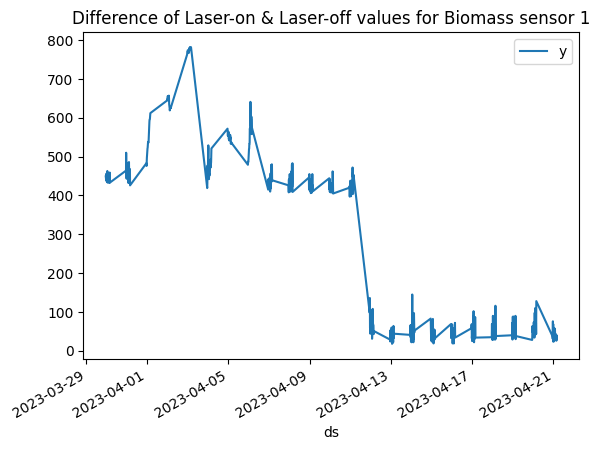

In [ ]:
value = pd.Series(bm1.on)
dates = pd.to_datetime(bm1.d_dt)
value.index = pd.DatetimeIndex(dates).tz_convert('US/Eastern')
value.plot()
plt.title("Laser-on values for Biomass sensor 1")
plt.show()

filtered_data.plot()
plt.title("Difference of Laser-on & Laser-off values for Biomass sensor 1")
plt.show()

Determine the order of the AR and MA terms (p and q) for the ARIMA model using the autocorrelation function (ACF) and partial autocorrelation function (PACF):

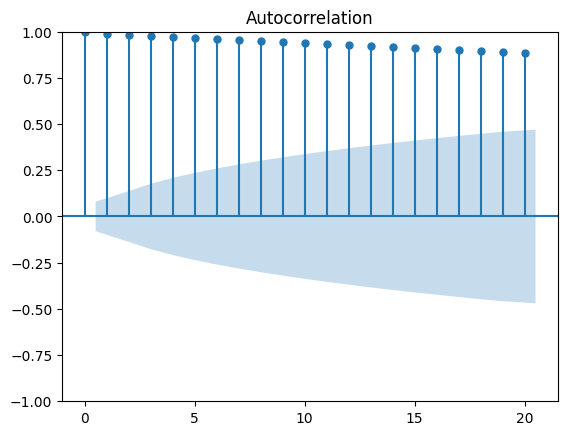

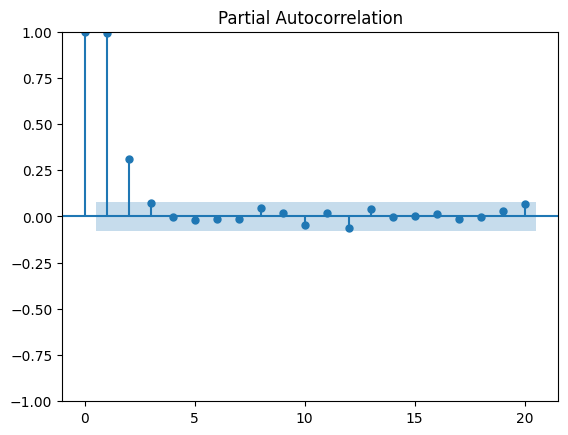

In [ ]:
sm.graphics.tsa.plot_acf(filtered_data, lags=20)
plt.show()

sm.graphics.tsa.plot_pacf(filtered_data, lags=20)
plt.show()

In [ ]:
p,d,q = 1,0,1
model = ARIMA(filtered_data, order=(p, d, q))
results = model.fit()
print(results.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  602
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2926.707
Date:                Fri, 21 Apr 2023   AIC                           5861.415
Time:                        16:44:57   BIC                           5879.016
Sample:                             0   HQIC                          5868.265
                                - 602                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        306.9918    231.614      1.325      0.185    -146.964     760.947
ar.L1          0.9957      0.004    236.846      0.000       0.988       1.004
ma.L1         -0.3078      0.020    -15.510      0.0

In [ ]:
train_size = int(len(filtered_data) * 0.85)
train, test = filtered_data.iloc[:train_size], filtered_data.iloc[train_size:]
# from pmdarima.arima import auto_arima
# model = auto_arima(train, trace=True,  suppress_warnings=True)
# predictions = model.predict(n_periods=len(test))
# plt.plot(test, color='green')
# plt.plot(train)
# plt.plot(predictions, color='red')
# plt.show()

ARIMA being a complex model is being overfitted to the data in the auto_arima api model as the data we have is very less for such a complex model


# Moving Average Forecast model

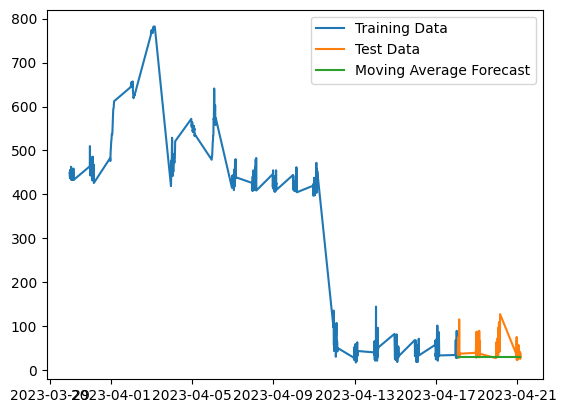

In [ ]:
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing

# Moving Averag8 (MA) model
window_size = 2
ma_predictions = test.copy()
ma_predictions['forecast'] = train['y'].rolling(window_size).mean().iloc[-1]
plt.plot(train['y'], label='Training Data')
plt.plot(test['y'], label='Test Data')
plt.plot(ma_predictions['forecast'], label='Moving Average Forecast')
plt.legend()
plt.show()

 # Exponential Smoothing model

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


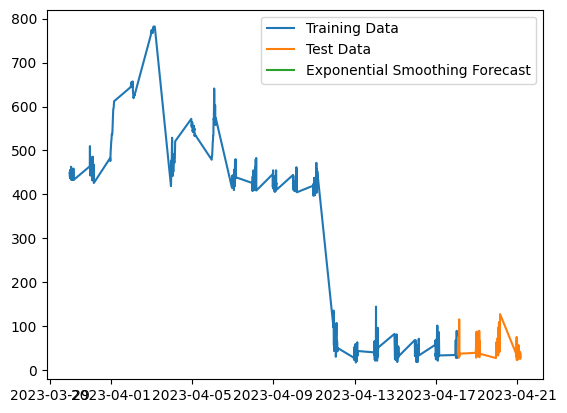

In [ ]:
alpha = 0.2 # smoothing constant
es_model = SimpleExpSmoothing(train['y']).fit(smoothing_level=alpha)
es_predictions = test.copy()
es_predictions['forecast'] = es_model.forecast(len(test))
plt.plot(train['y'], label='Training Data')
plt.plot(test['y'], label='Test Data')
plt.plot(es_predictions['forecast'], label='Exponential Smoothing Forecast')
plt.legend()
plt.show()


# LSTM model

In [ ]:
f.set_test_length(30)       # 1. 30 observations to test the results
f.generate_future_dates(50) # 2. 50 future points to forecast
f.set_estimator('lstm')     # 3. LSTM neural network

18/18 [==============================] - 0s 1ms/step


/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_default. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_24lags. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_24lags_15epochs. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_24lags_earlystop_3layers. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


<Axes: xlabel='Date', ylabel='Values'>

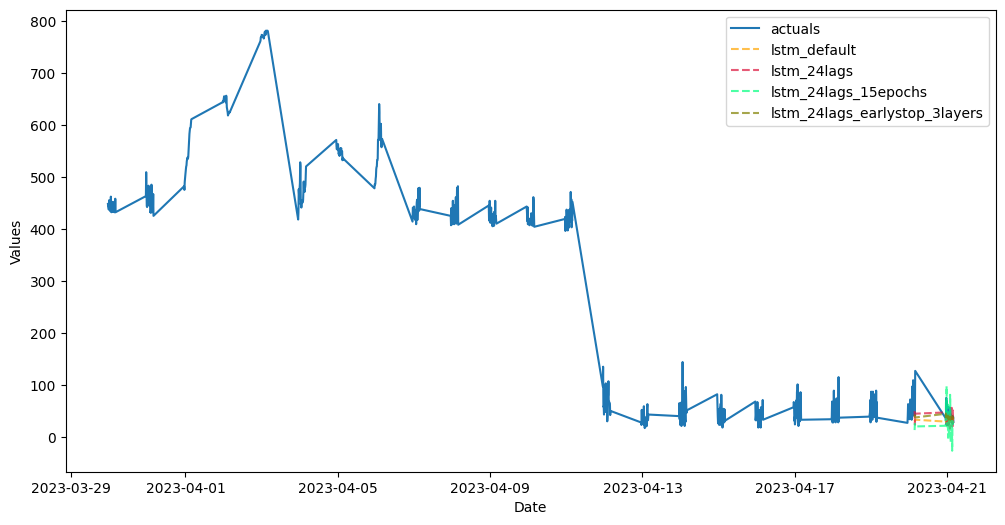

In [ ]:
f.manual_forecast(call_me='lstm_default')
f.plot_test_set(ci=True)

17/17 [==============================] - 0s 2ms/step


/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_default. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_24lags. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


<Axes: xlabel='Date', ylabel='Values'>

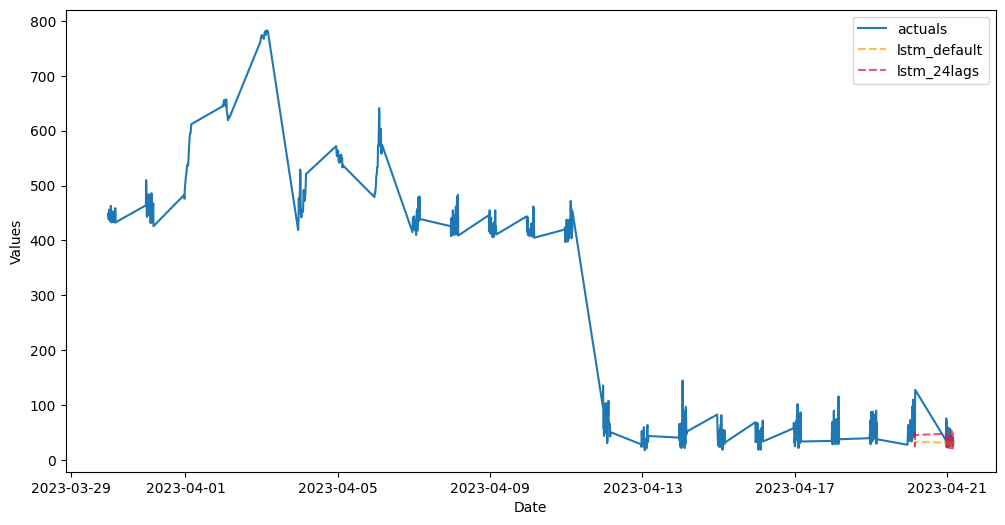

In [ ]:
f.manual_forecast(call_me='lstm_24lags',lags=24)
f.plot_test_set(ci=True)

Epoch 1/15
13/13 [==============================] - 2s 49ms/step - loss: 0.4537 - val_loss: 0.0288
Epoch 2/15
13/13 [==============================] - 0s 9ms/step - loss: 0.4274 - val_loss: 0.0260
Epoch 3/15
13/13 [==============================] - 0s 11ms/step - loss: 0.3961 - val_loss: 0.0386
Epoch 4/15
13/13 [==============================] - 0s 12ms/step - loss: 0.3498 - val_loss: 0.0738
Epoch 5/15
13/13 [==============================] - 0s 13ms/step - loss: 0.2968 - val_loss: 0.1155
Epoch 6/15
13/13 [==============================] - 0s 11ms/step - loss: 0.2478 - val_loss: 0.0782
Epoch 7/15
13/13 [==============================] - 0s 11ms/step - loss: 0.2023 - val_loss: 0.0427
Epoch 8/15
13/13 [==============================] - 0s 13ms/step - loss: 0.1674 - val_loss: 0.0380
Epoch 9/15
13/13 [==============================] - 0s 12ms/step - loss: 0.1448 - val_loss: 0.0443
Epoch 10/15
13/13 [==============================] - 0s 11ms/step - loss: 0.1305 - val_loss: 0.0481
Epoch 11/1

/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_default. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_24lags. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_24lags_15epochs. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


<Axes: xlabel='Date', ylabel='Values'>

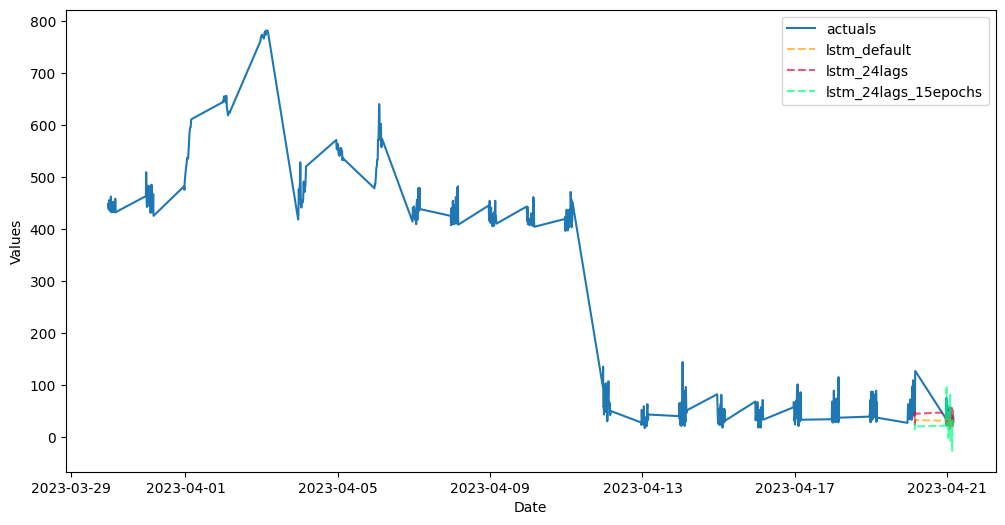

In [ ]:
f.manual_forecast(
    call_me='lstm_24lags_15epochs',
    lags=24,
    epochs=15,
    validation_split=.2,
    shuffle=True,
)
f.plot_test_set(ci=True)

Epoch 1/25
13/13 [==============================] - 7s 162ms/step - loss: 0.4611 - val_loss: 0.0404
Epoch 2/25
13/13 [==============================] - 0s 32ms/step - loss: 0.3862 - val_loss: 0.0992
Epoch 3/25
13/13 [==============================] - 0s 31ms/step - loss: 0.3020 - val_loss: 0.0401
Epoch 4/25
13/13 [==============================] - 0s 32ms/step - loss: 0.2273 - val_loss: 0.0408
Epoch 5/25
13/13 [==============================] - 0s 34ms/step - loss: 0.1751 - val_loss: 0.0429
Epoch 6/25
13/13 [==============================] - 0s 33ms/step - loss: 0.1314 - val_loss: 0.0373
Epoch 7/25
13/13 [==============================] - 0s 34ms/step - loss: 0.1091 - val_loss: 0.0336
Epoch 8/25
13/13 [==============================] - 0s 32ms/step - loss: 0.0986 - val_loss: 0.0312
Epoch 9/25
13/13 [==============================] - 0s 31ms/step - loss: 0.0934 - val_loss: 0.0291
Epoch 10/25
13/13 [==============================] - 1s 40ms/step - loss: 0.0913 - val_loss: 0.0274
Epoch 11

/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_default. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_24lags. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_24lags_15epochs. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_24lags_earlystop_3layers. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


<Axes: xlabel='Date', ylabel='Values'>

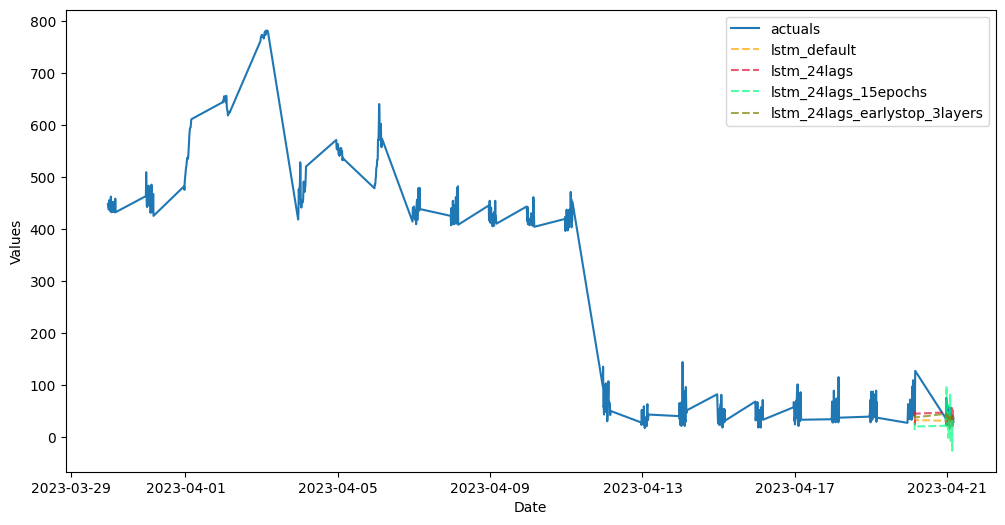

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

f.manual_forecast(
    call_me='lstm_24lags_earlystop_3layers',
    lags=24,
    epochs=25,
    validation_split=.2,
    shuffle=True,
    callbacks=EarlyStopping(
        monitor='val_loss',               
        patience=5,
    ),
    lstm_layer_sizes=(16,16,16),
    dropout=(0,0,0),
)

f.plot_test_set(ci=True)